# Train a CNN

In this notebook we will go through all the steps required to train a fully convolutional neural network. Because this takes a while and uses a lot of GPU RAM a separate command line script (`train_nn.py`) is also provided in the `src` directory.

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict

In [38]:
tf.__version__

'2.1.0'

In [39]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)

In [40]:
limit_mem()

In [41]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [42]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [43]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

In [44]:
# For the data generator all variables have to be merged into a single dataset.
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    #'specific_humidity': ('q', [850]),
    '2m_temperature': ('t2m', None),
    #'potential_vorticity': ('pv', [50, 100]),
    'constants': ['orography']
}

In [10]:
# For the data generator all variables have to be merged into a single dataset.
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)        

In [14]:
import re

bs=32
lead_time=72
output_vars = ['z_500', 't_850']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std,
                         shuffle=False, output_vars=output_vars)


Loading data into RAM
Loading data into RAM
Loading data into RAM


## Load predictions

In [15]:
# use only batch normalisation
# produced by whole_only_bn_mm.py

pred_ensemble_1 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_mm_extra_data_0.npy')
pred_ensemble_2 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_mm_extra_data_1.npy')
pred_ensemble_3 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_mm_extra_data_2.npy')
pred_ensemble_4 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_mm_extra_data_3.npy')

In [24]:
samples = 1
preds_1 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

preds_2 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_2[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_2[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

preds_3 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_3[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_3[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

preds_4 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

In [26]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [27]:
real_unnorm =y1* dg_test.std.isel(level=[0,1]).values+dg_test.mean.isel(level=[0,1]).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [28]:
cnn_rmse = compute_weighted_rmse(preds_1, real_ds).compute()
print(cnn_rmse)

cnn_rmse_2 = compute_weighted_rmse(preds_2, real_ds).compute()
print(cnn_rmse_2)

cnn_rmse_3 = compute_weighted_rmse(preds_3, real_ds).compute()
print(cnn_rmse_3)

cnn_rmse_4 = compute_weighted_rmse(preds_4, real_ds).compute()
print(cnn_rmse_4)

preds_total = (preds_1 + preds_2 + preds_3 + preds_4)/4

cnn_rmse_total = compute_weighted_rmse(preds_total, real_ds).compute()
cnn_rmse_total

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.756
    z        float64 615.8
<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.788
    z        float64 618.0
<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.772
    z        float64 618.7
<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.764
    z        float64 617.2


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.702
    z        float64 602.6

In [29]:
cnn_total_2 = compute_weighted_rmse((preds_1+preds_2)/2, real_ds)
cnn_total_3 = compute_weighted_rmse((preds_1+preds_2+preds_3)/3, real_ds)

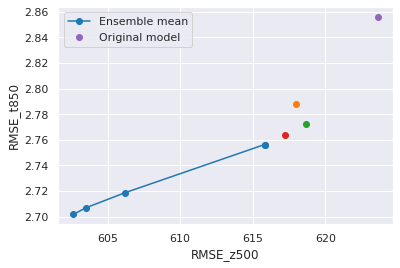

In [35]:
# effect of doing ensembles
plt.scatter(cnn_rmse.z, cnn_rmse.t)
plt.scatter(cnn_rmse_2.z, cnn_rmse_2.t)
plt.scatter(cnn_rmse_3.z, cnn_rmse_3.t)
plt.scatter(cnn_rmse_4.z, cnn_rmse_4.t)
plt.plot([cnn_rmse.z, cnn_total_2.z, cnn_total_3.z, cnn_rmse_total.z], [cnn_rmse.t, cnn_total_2.t, cnn_total_3.t, cnn_rmse_total.t], 'o-', label = 'Ensemble mean')
plt.scatter([623.6], [2.856], label = 'Original model')
plt.xlabel('RMSE_z500')
plt.ylabel('RMSE_t850')
plt.legend()
plt.savefig('full_moredata.png')
plt.show()

In [47]:
print([cnn_rmse.z.data, cnn_total_2.z.data, cnn_total_3.z.data, cnn_rmse_total.z.data])
print([cnn_rmse.t.data, cnn_total_2.t.data, cnn_total_3.t.data, cnn_rmse_total.t.data])

[array(615.81100858), array(606.20085112), array(603.49767756), array(602.63237168)]
[array(2.75629372), array(2.7187251), array(2.70695138), array(2.70178747)]


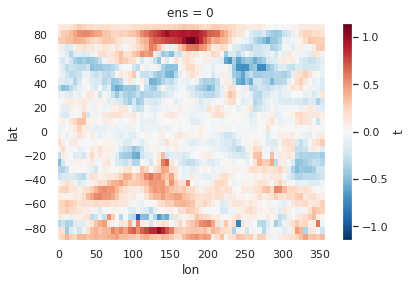

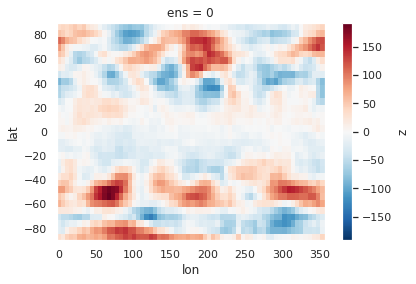

In [31]:
mean_ens_t = sum([real_ds.t.isel(time = i)-preds_total.t.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_t.plot()
plt.show()
mean_ens_z = sum([real_ds.z.isel(time = i)-preds_total.z.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_z.plot()
plt.show()

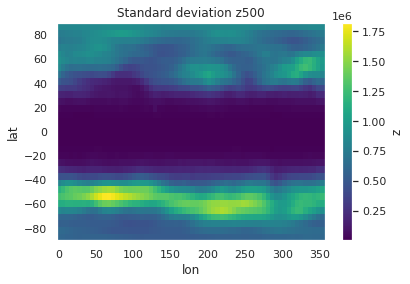

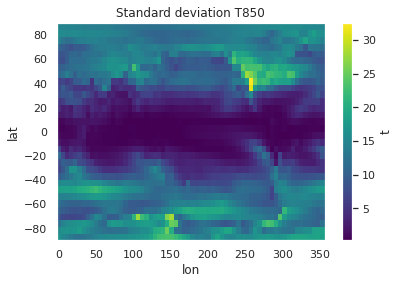

In [32]:
meansq_ens_z = sum([(real_ds.z.isel(time = i)-preds_total.z.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_z-mean_ens_z**2).plot()
plt.title('Standard deviation z500')
plt.show()
meansq_ens_t = sum([(real_ds.t.isel(time = i)-preds_total.t.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_t-mean_ens_t**2).plot()
plt.title('Standard deviation T850')
plt.show()